In [1]:
# Imports
%load_ext autoreload
%autoreload 2

from os.path import exists
from pathlib import Path

import math

import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn # Includes all modules, nn.Linear, nn.Conv2d, BatchNorm etc
import torch.optim as optim # Is used for otimization algorithms such as Adam, SGD ...
from torch.utils.data import DataLoader # Helps with managing datasets in mini batches
from torch.utils.data import Dataset

import torchvision
import torchvision.datasets as datasets # Has standard datasets
import torchvision.transforms as transforms # Transformations to be used on images
import torchvision.transforms as T
import torchvision.transforms.functional as F
from torchvision.models import vgg19

from itertools import chain
from PIL import Image

from model import Generator, Discriminator # Models
from loss import VGGContentLoss
from datahandler import DataHandler
from modelhandler import ModelHandler
from utils import display_image, save_result_images
from train import train_loop
import config

In [2]:
print("cuda is available: " + str(torch.cuda.is_available()))
device = config.DEVICE
print("Device is set to: " + str(config.DEVICE))

cuda is available: True
Device is set to: cuda


Text(0.5, 1.0, 'High res (96 x 96 px)')

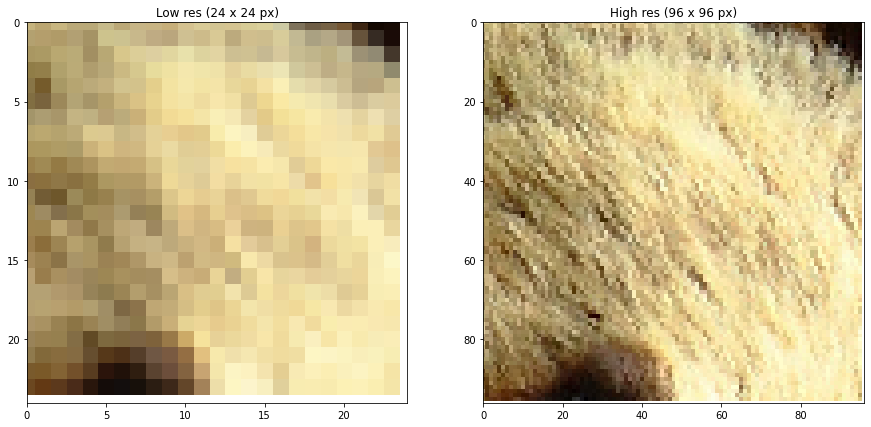

In [3]:
# The Dataset constructor has a transform attribute, we will cover it below. Just use this for now:
high_res_size = 96
low_res_size = 24

example_dataset = DataHandler("./dataset/", high_res_size ,low_res_size);
fig, axis = plt.subplots(1,2, figsize=(15,15))
some_random_index = 4
high_res_image_tensor, low_res_image_tensor = example_dataset[some_random_index]
display_image(axis[0], low_res_image_tensor)
axis[0].set_title('Low res (' + str(low_res_size) + ' x ' + str(low_res_size) + ' px)')
display_image(axis[1], high_res_image_tensor, reverse_normalization = True)
axis[1].set_title('High res (' + str(high_res_size) + ' x ' + str(high_res_size) + ' px)')

In [4]:
# Initialize models (with ModelHandler)
model_handler = ModelHandler()
generator, discriminator, disc_opti, gen_opti, gen_opti_pretrain, config_dict = model_handler.load_models()

# Initialize data
datahandler = DataHandler("./dataset/", config_dict['HIGH_RES_SIZE'] ,config_dict['LOW_RES_SIZE']);
train_dataloader = DataLoader(datahandler, batch_size=config_dict['BATCH_SIZE'], shuffle=True)

Load procedure initialized..
Enter stem of path (leave empty for new models): 
Loading models from scratch
high_res_size:           96
low_res_size:            24
scaling_factor:          2
batch_size:              32
num_epochs_train:        150
num_epochs_pretrain:     50
gen_lr:                  0.0001
gen_lr_pretrain:         0.001
disc_lr:                 0.0001
use_inception_blocks:    False
pixel_weight:            0.001
content_weight:          0.006
adversarial_weight:      0.001


In [5]:
# TRAINING TIME!
# Generator training (Pretraining)
generator, discriminator, disc_opti, gen_opti, gen_opti_pretrain, config_dict = train_loop(train_dataloader, generator, discriminator,  disc_opti, gen_opti, gen_opti_pretrain, config_dict, adversarial=False)

# Adversarial training (Regular Training)
generator, discriminator, disc_opti, gen_opti, gen_opti_pretrain, config_dict = train_loop(train_dataloader, generator, discriminator,  disc_opti, gen_opti, gen_opti_pretrain, config_dict, adversarial=True)

In [6]:
# Save the model
folder_path = model_handler.save_models(generator, discriminator, disc_opti, gen_opti, gen_opti_pretrain, config_dict)

# Save result images
if folder_path:
    save_result_images(generator, datahandler, folder_path)

Saving procedure initialized..
Enter stem of path (leave empty if you don't want to save): save-image-test
Saved succesfully
Succesfully saved result images in 


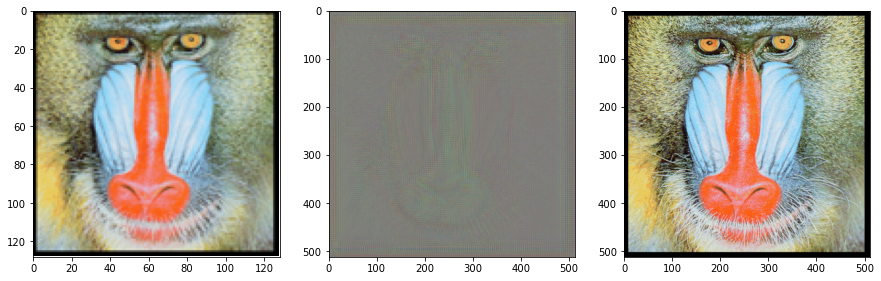

In [9]:
# placeholder code for displaying an image from generator
with torch.no_grad():
    img_lr = datahandler.get_sample_by_name('baboon', 128)
    img_hr = datahandler.get_sample_by_name('baboon', 512)
    fig, ax = plt.subplots(1, 3, figsize=(15,15))
    display_image(ax[0], img_lr)
    display_image(ax[1], generator.forward(torch.unsqueeze(img_lr.cuda().detach(), 0))[-1].cpu(), reverse_normalization=True)
    display_image(ax[2], img_hr)